In [2]:
import pickle
import pandas as pd
import os
import AmazonScraper



import numpy as np
from scipy import stats
import requests
from bs4 import BeautifulSoup
import pandas as pd
from subprocess import call

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import bisect
import diagnostic_plots


import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.neighbors.kde import KernelDensity
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
import matplotlib.pyplot as plt
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import MinMaxScaler
% matplotlib inline


from IPython.core.pylabtools import figsize
figsize(5,5)
plt.style.use('fivethirtyeight')

from sklearn.model_selection import learning_curve
#import diagnostic_plots

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
    
import warnings
warnings.filterwarnings('ignore')

/home/williamcottrell72/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [115]:
def get_polynomial_features(degree, x_values):
    return PolynomialFeatures(degree=degree).fit_transform(x_values)


def build_df():
    test=1
    x=100
    data=[]
    while test:
        name=f'cache/cache_{x}.pkl'
        try:
            with open(name,'rb') as pkl:
                data_temp=pickle.load(pkl)
            data+=data_temp
            x+=100
        except:
            test=0
            return pd.DataFrame(data,columns=['url','stars','pics','descriptors','desLength','price'])

def fix_row(row):
    return [float(x) for x in list(row)]

def MSE(a,b):
    try:
        a=a.values
    except(AttributeError):
        pass
    try:
        b=b.values
    except(AttributeError):
        pass
    return (sum([(a[i]-b[i])**2 for i in range(len(a))])/len(a))[0]

def R2(a,b):
    try:
        a=a.values
    except(AttributeError):
        pass
    try:
        b=b.values
    except(AttributeError):
        pass
    mean_pred=[np.mean(b) for i in range(len(b))]
    return 1-MSE(a,b)/MSE(mean_pred,b)

def R2_adj(a,b,p):
    n=len(a)
    return (R2(a,b)-1)(n-1)/(n-1-p)+1


def clean_df():
    df=build_df()
    clean1=df.dropna().drop(columns=['url'])
    clean2=[]
    for i in range(clean1.shape[0]):
        try:
            clean_row=[fix_row(clean1.iloc[i])]
            clean2+=clean_row
        except:
            pass
    return pd.DataFrame(clean2,columns=['stars','pics','descriptors','desLength','price'])



def make_cdf(x,n):
    s=min(x)
    m=max(x)
    bins=np.linspace(s,m,n)
    cdf=[]
    for i in bins:
        ct=0
        for j in x:
            if j<i:
                ct+=1
        cdf.append(ct/len(x))
    return bins, cdf

In [4]:
df=clean_df()
df=df[df.price<30]
df.shape

(5336, 5)

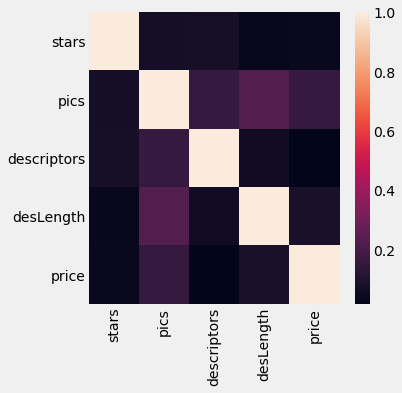

In [16]:
sns.heatmap(df.corr())

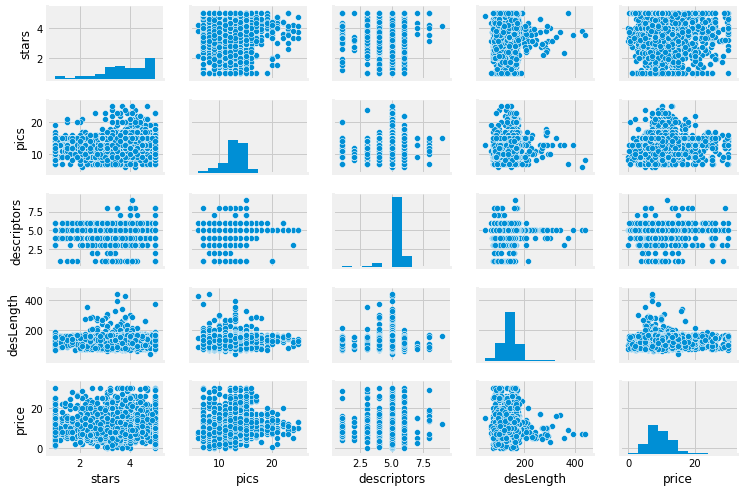

In [7]:
sns.pairplot(df, size = 1.4, aspect=1.5);

## Our goal is not to transform all variables to gaussian so as to achieve homodasticity.  Let's look at some of the histograms individually.

### Price

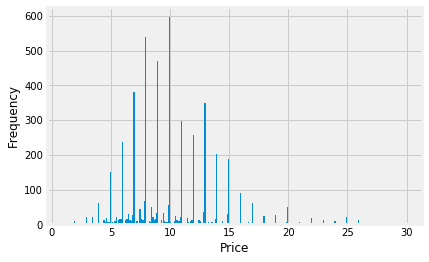

In [8]:
plt.hist(df['price'].values,bins=np.arange(1,30,.1))
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

This graph shows the strong tendency to gravitate towards certain fixes prices, e.g., prices ending in '.95', etc.

### Description Length

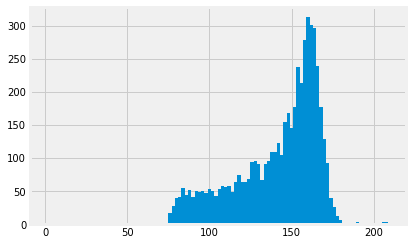

In [9]:
plt.hist(df['desLength'].values,bins=np.arange(1,210,2))
plt.show()

This has a lot of structure and is definitely not close to a gaussian...

### Price Versus Stars

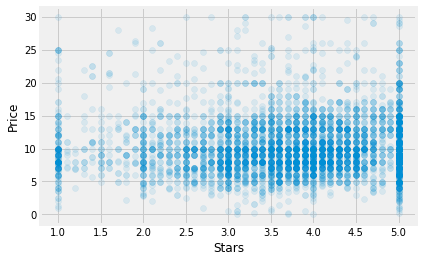

In [10]:
plt.scatter(df['stars'],df['price'],alpha=.1)
plt.xlabel("Stars")
plt.ylabel("Price")
plt.show()

## Number of Pictures

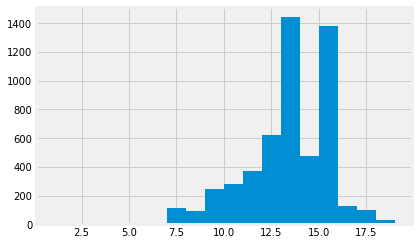

In [11]:
plt.hist(df['pics'].values,bins=np.arange(1,20,1))
plt.show()

...hmmmm

# Summary Statistics for Baseline Model

It is convenient to use **statsmodels** to get a summary of the statistics for a baseline model.  Our baseline model will assume quadratic terms for the number of pictures, description length, number of descriptors, and number of stars.

In [12]:
def square(x):
    return x**2
df['pics_squared']=df['pics'].apply(square)
df['desLength_squared']=df['desLength'].apply(square)
df['descriptors_squared']=df['descriptors'].apply(square)
df['stars_squared']=df['stars'].apply(square)

In [13]:
y_baseline, X_baseline = patsy.dmatrices('price ~ desLength+descriptors+stars+pics +\
 pics_squared+desLength_squared+descriptors_squared', data=df, return_type="dataframe")

#y_baseline, X_baseline = patsy.dmatrices('price ~ desLength+descriptors+stars+pics', data=df, return_type="dataframe")

# Create your model
model = sm.OLS(y_baseline,X_baseline)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     25.88
Date:                Mon, 16 Jul 2018   Prob (F-statistic):           4.59e-35
Time:                        23:20:33   Log-Likelihood:                -15128.
No. Observations:                5336   AIC:                         3.027e+04
Df Residuals:                    5328   BIC:                         3.032e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.6274      1.327      2.733      0.006       1.026       6.229
desLength               0.0327      0.007      4.588      0.000       0.019       0.047
descriptors            -0.9373      0.405     -2.313      0.021      -1.732      -0.143
stars                   0.1058      0.056      1.906      0.057      -0.003       0.215
pics                    0.6466      0.147      4.396      0.000       0.358       0.935
pics_squared           -0.0154      0.006     -2.774      0.006      -0.026      -0.005
desLength_squared   -8.357e-05   2.23e-05     -3.753      0.000      -0.000   -3.99e-05
descriptors_squared     0.0904      0.044      2.051      0.040       0.004       0.177
==============================================================================
Omnibus:                     1621.306   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5542.355
Skew:                           1.517   Prob(JB):                         0.00
Kurtosis:                       6.965   Cond. No.                     5.49e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.49e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
y_predict_baseline=fit.predict(X_baseline)

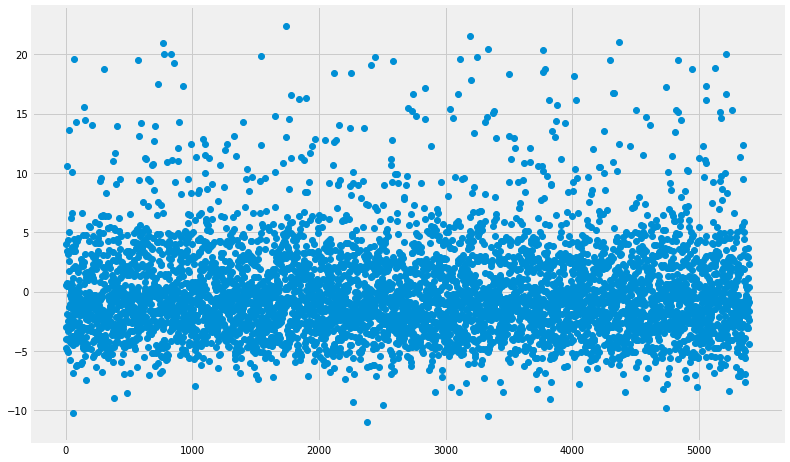

In [28]:
fit.resid.plot(style='o', figsize=(12,8));

I would have thought that stars would be a stronger predictor.  Let's just look at the effect of stars alone.

In [30]:
y_stars, X_stars = patsy.dmatrices('price ~ stars+stars_squared', data=df, return_type="dataframe")

# Create your model
model = sm.OLS(y_stars,X_stars)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     7.157
Date:                Mon, 16 Jul 2018   Prob (F-statistic):           0.000787
Time:                        23:32:09   Log-Likelihood:                -15210.
No. Observations:                5336   AIC:                         3.043e+04
Df Residuals:                    5333   BIC:                         3.045e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        10.7207      0.492     21.781      0.000       9.756      11.686
stars            -0.5543      0.300     -1.847      0.065      -1.143       0.034
stars_squared     0.1069      0.044      2.431      0.015       0.021       0.193
==============================================================================
Omnibus:                     1369.314   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4015.835
Skew:                           1.330   Prob(JB):                         0.00
Kurtosis:                       6.315   Cond. No.                         170.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Apparently, stars only help if there are 3 or more...

# Improved Model

We would now like to develop an improved model by applying some transforms to the data and also by including more general interaction terms.  In order to keep ourselves honest, we will split the data into a training and test set, and then apply k-fold validation to the training set to improve our model before applying to the test set.  I'll take the test set to be 1/5 the size of the dataset, and then apply 4-fold validation to the training set.

In [31]:
x=df.iloc[:,:4]
y=df.iloc[:,4:5]
X_train, X_test, y_train, y_test = train_test_split(x.values, y.values, test_size=0.2,random_state=42)

Now, we will forget about X_test and y_test for the remainder of the analysis.  It will only be recalled at the end, when we want to check our model.

In [32]:
for i in range(1,8):
    degree=i
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    # Fit our model to the training data
    fit=est.fit(X_train, y_train)
    scores = cross_val_score(est, X_train, y_train, cv=4, scoring='mean_squared_error')
    y_predict=fit.predict(X_train)
    mse=sum((y_train-y_predict)**2)/len(y_train)
    print(f"Degree: {i},   Naive Score: {est.score(X_train,y_train)},  Cross_Val: {np.mean(scores)},   MSE: {mse}")
    

Degree: 1,   Naive Score: 0.030422018159846794,  Cross_Val: -17.54797877249077,   MSE: [17.4934361]
Degree: 2,   Naive Score: 0.041373556877219886,  Cross_Val: -17.466653524436694,   MSE: [17.29584493]
Degree: 3,   Naive Score: 0.05326384677718998,  Cross_Val: -17.79277185674773,   MSE: [17.08131652]
Degree: 4,   Naive Score: 0.06788349264939775,  Cross_Val: -19.446173568837825,   MSE: [16.81754419]
Degree: 5,   Naive Score: 0.09146098238328315,  Cross_Val: -59.24840016603969,   MSE: [16.39215158]
Degree: 6,   Naive Score: 0.10460256246094701,  Cross_Val: -38874.43799544292,   MSE: [16.15504699]
Degree: 7,   Naive Score: 0.0974651430524377,  Cross_Val: -24235.120378994943,   MSE: [16.28382259]


In [34]:
est = make_pipeline(PolynomialFeatures(2), LinearRegression())
fit_ut=est.fit(X_train, y_train)
y_test_predict=fit_ut.predict(X_test)
R2(y_test_predict,y_test)

0.017619537120393103

Apparently, a quadratic fit does the best under cross-validation.  Let's take a look at the residuals for the quadratic model.

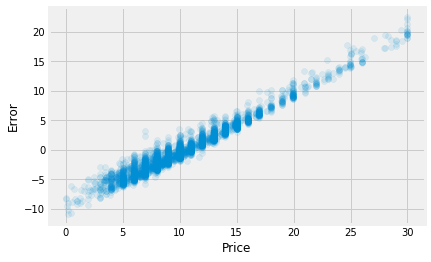

In [35]:
quadratic_model=make_pipeline(PolynomialFeatures(2), LinearRegression())
quadratic_model.fit(X_train,y_train)
y_train_predict=quadratic_model.predict(X_train)
residuals=y_train-y_train_predict

plt.scatter(y_train,residuals,alpha=.1)
plt.xlabel("Price")
plt.ylabel("Error")
plt.show()

The residual plot shows that we are still missing a lot of structure.  Naively, the linear tilt seen here could be removed by a linear transformation of the fitting function.  However, any such transformation would necessarily make the error based on our scoring function worse.  


The scoring function being used so far is the mean squared error.  This scoring function is only good if the data is homoskedastic.  Apparently our data is heteroscedastic.  We would like to see if this can be fixed by applying an appropriate non-linear transformation.  (An possible alternative is to consider other scoring functions as well.)

Another interesting point is that the data looks much less structured if we plot against the predicted values.

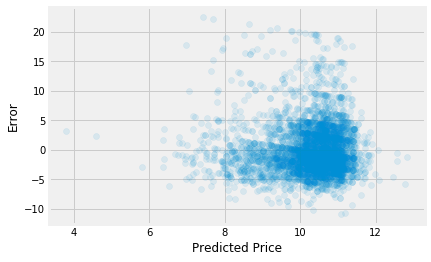

In [38]:
plt.scatter(y_train_predict,residuals,alpha=.1)
plt.xlabel("Predicted Price")
plt.ylabel("Error")
plt.show()

In [ ]:
## Lasso, Ridge, etc.  

In [39]:
from sklearn.linear_model import RidgeCV
alphas=[10**(float(i)/10) for i in np.arange(-100,10,1)]
best_alphas=[]

for i in range(1,8):
    degree=i
    est = make_pipeline(PolynomialFeatures(degree), RidgeCV(cv=4,alphas=alphas))
    # Fit our model to the training data
    rcv=est.fit(X_train, y_train)
    s_train=rcv.score(X_train,y_train)
    s_test=rcv.score(X_test,y_test)
    #best_alphas.append(rcv.alpha_)
    scores = cross_val_score(est, X_train, y_train, cv=4, scoring='mean_squared_error')
    y_predict=rcv.predict(X_train)
    mse=sum((y_train-y_predict)**2)/len(y_train)
    print(f"Degree: {i},   RCV_score: {s_train},  Cross_Val: {s_test},   MSE: {mse[0]}, CVS: {np.mean(scores)}")
    

Degree: 1,   RCV_score: 0.030422001367414908,  Cross_Val: 0.012014387331024445,   MSE: 17.493436400967596, CVS: -17.54783324371421
Degree: 2,   RCV_score: 0.04127757229876017,  Cross_Val: 0.017563876960360325,   MSE: 17.297576717732728, CVS: -17.449752397364687
Degree: 3,   RCV_score: 0.05298103218852612,  Cross_Val: 0.013202386241858544,   MSE: 17.08641915068641, CVS: -17.67171449670294
Degree: 4,   RCV_score: 0.06710875744489375,  Cross_Val: -0.1073214705073049,   MSE: 16.831522212419326, CVS: -18.667059381839877
Degree: 5,   RCV_score: 0.0866804071048135,  Cross_Val: -2.259808327725239,   MSE: 16.47840424865497, CVS: -38.30722306524996
Degree: 6,   RCV_score: 0.1061242415773761,  Cross_Val: -163.81194792761977,   MSE: 16.12759236738656, CVS: -1953.2855089458694
Degree: 7,   RCV_score: 0.14495713659615928,  Cross_Val: -6883.769370079514,   MSE: 15.426956853550067, CVS: -205483.53735225808


In [85]:
from sklearn.linear_model import LassoCV
alphas=[10**(float(i)) for i in np.arange(-10,1,1)]
best_alphas=[]

for i in range(1,8):
    degree=i
    est = make_pipeline(PolynomialFeatures(degree), LassoCV(cv=4,alphas=alphas))
    # Fit our model to the training data
    rcv=est.fit(X_train, y_train)
    s_train=rcv.score(X_train,y_train)
    s_test=rcv.score(X_test,y_test)
    #best_alphas.append(rcv.alpha_)
    scores = cross_val_score(est, X_train, y_train, cv=4, scoring='mean_squared_error')
    y_predict=rcv.predict(X_train)
    mse=sum((y_train-y_predict)**2)/len(y_train)
    print(f"Degree: {i},   RCV_score: {s_train},  Cross_Val: {s_test},   MSE: {mse[0]}, CVS: {np.mean(scores)}")
    

Degree: 1,   RCV_score: 0.030398085740333872,  Cross_Val: 0.012671181253478103,   MSE: 19.081897858331335, CVS: -17.5509454823782
Degree: 2,   RCV_score: 0.04022577363232738,  Cross_Val: 0.016508611988708122,   MSE: 18.824891831651076, CVS: -17.459752434927317
Degree: 3,   RCV_score: 0.04055493325204096,  Cross_Val: 0.01460377985413197,   MSE: 18.894299789256653, CVS: -17.454283125369656
Degree: 4,   RCV_score: 0.04591135391871759,  Cross_Val: 0.00986859241899507,   MSE: 18.962178733316115, CVS: -17.57316111787474
Degree: 5,   RCV_score: 0.04903269797467302,  Cross_Val: 0.003730887591583576,   MSE: 18.95677311756354, CVS: -17.690119926216113
Degree: 6,   RCV_score: 0.05264333333467097,  Cross_Val: -0.0031376101639994936,   MSE: 18.887515011363522, CVS: -17.999163417211054
Degree: 7,   RCV_score: 0.057071972823443895,  Cross_Val: -0.006571161227321154,   MSE: 18.88132957699238, CVS: -19.113044775877334


## Data Transforms

Looking at the histograms, can we find transforms which make the variables individually gaussian?

### Price

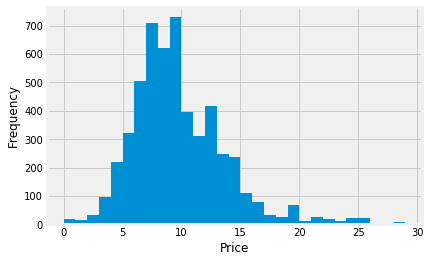

In [40]:
plt.hist(df['price'],bins=np.arange(0,30,1))
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

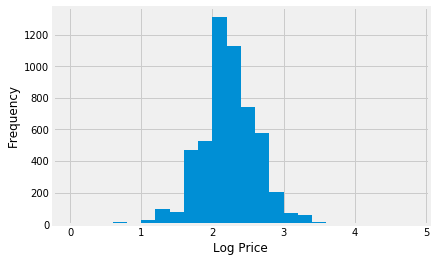

In [41]:
plt.hist(df['price'].apply(np.log),bins=np.arange(0,5,.2))
plt.xlabel("Log Price")
plt.ylabel("Frequency")
plt.show()

This looks a bit better.  Let's use this variable for price instead.

In [42]:
df['log_price']=df['price'].apply(np.log)

### Description Length

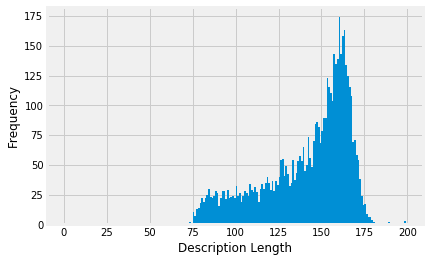

In [43]:
plt.hist(df['desLength'],bins=np.arange(0,200,1))
plt.xlabel("Description Length")
plt.ylabel("Frequency")
plt.show()

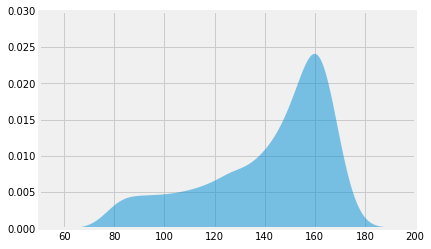

In [44]:
kde = KernelDensity(bandwidth=5.0, kernel='gaussian')
data=df['desLength'].values
kde.fit(data[:, None])
bins=np.arange(50,440,1)
bins2=np.arange(50,440,.01)

# score_samples returns the log of the probability density
logprob = kde.score_samples(bins2[:,None])

plt.fill_between(bins2, np.exp(logprob), alpha=0.5)
#plt.plot(data, np.full_like(data, -0.01), '|k', markeredgewidth=1)
plt.ylim(0, 0.03)
plt.xlim(50,200)
plt.show()

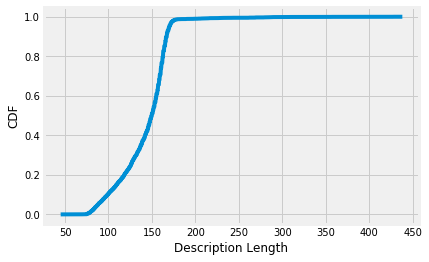

In [45]:
bins,cdf=make_cdf(data,1000)
plt.plot(bins,cdf)
plt.xlabel('Description Length')
plt.ylabel("CDF")
plt.show()

In [47]:
exponential=[.004*np.exp(-(x**2))/(np.pi**(1/2)) for x in np.linspace(-20,20,10000)]
exp_int=[sum(exponential[:i]) for i in range(10000)]
cdf_kde=[sum(np.exp(logprob)[:i]) for i in range(len(bins2))]/sum(np.exp(logprob))

In [48]:
# Let's do a mapping for one number and then generalize.

def cdf_map(price):
    #exponential=[.004*np.exp(-(x**2))/(np.pi**(1/2)) for x in np.linspace(-20,20,10000)]
    #exp_int=[sum(exponential[:i]) for i in range(10000)]    
    index=bisect.bisect(bins2,price)
    try:
        cdf1=cdf_kde[index]
        index2=bisect.bisect(exp_int,cdf1)
        return np.linspace(-20,20,10000)[index2]
    except:
        return 20

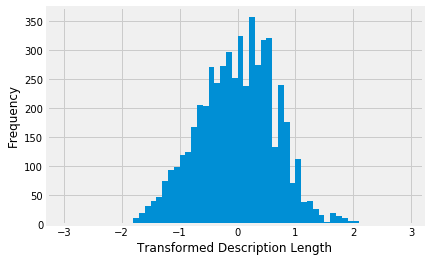

In [49]:
plt.hist(df['desLength'].apply(cdf_map),bins=np.arange(-3,3,.1))
plt.xlabel("Transformed Description Length")
plt.ylabel("Frequency")
plt.show()

Now let's apply our cdf_map, forcing the 'desLength' features to be gaussian.

In [51]:
df['dL_transformed']=df['desLength'].apply(cdf_map)
xt=df[['stars','pics','descriptors','dL_transformed']]
yt=df.iloc[:,4:5].apply(np.log)
Xt_train, Xt_test, yt_train, yt_test = train_test_split(xt.values, yt.values, test_size=0.2,random_state=42)

In [52]:
from sklearn.linear_model import LassoCV
alphas=[10**(float(i)) for i in np.arange(-10,1,1)]
best_alphas=[]

for i in range(1,8):
    degree=i
    est = make_pipeline(PolynomialFeatures(degree), LassoCV(cv=4,alphas=alphas))
    # Fit our model to the training data
    rcv=est.fit(X_train, y_train)
    s_train=rcv.score(X_train,y_train)
    s_test=rcv.score(X_test,y_test)
    #best_alphas.append(rcv.alpha_)
    scores = cross_val_score(est, X_train, y_train, cv=4, scoring='mean_squared_error')
    y_predict=rcv.predict(X_train)
    mse=sum((y_train-y_predict)**2)/len(y_train)
    print(f"Degree: {i},   RCV_score: {s_train},  Cross_Val: {s_test},   MSE: {mse[0]}, CVS: {np.mean(scores)}")
    

Degree: 1,   RCV_score: 0.030398085740333872,  Cross_Val: 0.012671181253478103,   MSE: 19.081897858331335, CVS: -17.5509454823782
Degree: 2,   RCV_score: 0.04022577363232738,  Cross_Val: 0.016508611988708122,   MSE: 18.824891831651076, CVS: -17.459752434927317
Degree: 3,   RCV_score: 0.04055493325204096,  Cross_Val: 0.01460377985413197,   MSE: 18.894299789256653, CVS: -17.454283125369656
Degree: 4,   RCV_score: 0.04591135391871759,  Cross_Val: 0.00986859241899507,   MSE: 18.962178733316115, CVS: -17.57316111787474
Degree: 5,   RCV_score: 0.04903269797467302,  Cross_Val: 0.003730887591583576,   MSE: 18.95677311756354, CVS: -17.690119926216113
Degree: 6,   RCV_score: 0.05264333333467097,  Cross_Val: -0.0031376101639994936,   MSE: 18.887515011363522, CVS: -17.999163417211054
Degree: 7,   RCV_score: 0.057071972823443895,  Cross_Val: -0.006571161227321154,   MSE: 18.88132957699238, CVS: -19.113044775877334


In [100]:
transformed_ridge_scores=[]
alphas=[10**(float(i)) for i in np.arange(-10,1,1)]
best_alphas_transformed=[]
for i in range(1,9):
    degree=i
    est = make_pipeline(PolynomialFeatures(degree), RidgeCV(cv=4,alphas=alphas))
    # Fit our model to the training data
    fit_t=est.fit(Xt_train, yt_train)
    s_train=fit_t.score(Xt_train,yt_train)
    s_test=fit_t.score(Xt_test,yt_test)
    yt_train_predict=fit2.predict(Xt_train)
    MSE=sum([(yt_train[i]-yt_train_predict[i])**2 for i in range(len(yt_train))])/len(yt_train)
    scores = cross_val_score(est, Xt_train, yt_train, cv=4, scoring='mean_squared_error')
    transformed_ridge_scores.append([s_train,s_test,mse[0],np.mean(scores)])
    print(f"Degree: {i},   4-fold Score: {s_train},  Test Score: {s_test},   MSE: {mse[0]}, CVS: {np.mean(scores)}")
    

Degree: 1,   4-fold Score: 0.05471269483549823,  Test Score: 0.04415714900282186,   MSE: 18.88132957699238, CVS: -0.20058037716551327
Degree: 2,   4-fold Score: 0.06633489491148958,  Test Score: 0.05002973458002557,   MSE: 18.88132957699238, CVS: -0.21380573955296622
Degree: 3,   4-fold Score: 0.0854057024853222,  Test Score: 0.01381159430504908,   MSE: 18.88132957699238, CVS: -1.631474511484125
Degree: 4,   4-fold Score: 0.10630494531839174,  Test Score: -0.014643128987887222,   MSE: 18.88132957699238, CVS: -40.06967058213685
Degree: 5,   4-fold Score: 0.13547994531491336,  Test Score: -0.18634978277281689,   MSE: 18.88132957699238, CVS: -71468.60980970145
Degree: 6,   4-fold Score: 0.16516611482887045,  Test Score: -1.522627595348276,   MSE: 18.88132957699238, CVS: -7436738.762426034
Degree: 7,   4-fold Score: 0.21902018389357525,  Test Score: -381.8631990348907,   MSE: 18.88132957699238, CVS: -8546942211.135173
Degree: 8,   4-fold Score: 0.24167014255670827,  Test Score: -318.451224

Let's focus on the quadratic model after data transformation.  If we transform back, what do the scores look like?

In [57]:

est = make_pipeline(PolynomialFeatures(2), RidgeCV(cv=4,alphas=alphas))
rcv=est.fit(Xt_train, yt_train)
yt_train_predict=rcv.predict(Xt_train)
yt_test_predict=rcv.predict(Xt_test)
yut_train_predict=np.exp(yt_train_predict)
yut_test_predict=np.exp(yt_test_predict)
ut_train_score=MSE(yut_train_predict,y_train)
ut_test_score=MSE(yut_test_predict,y_test)

In [56]:
ut_test_score, ut_train_score, R2(yut_test_predict,y_test)

(15.851696189522112, 18.158403298251613, -0.013747802833944833)

sklearn.pipeline.Pipeline

In [ ]:
alphas=[10**(float(i)) for i in np.arange(-10,1,1)]
best_alphas=[]

for i in range(1,8):
    degree=i
    est = make_pipeline(PolynomialFeatures(degree), RidgeCV(cv=4,alphas=alphas))
    # Fit our model to the training data
    rcv=est.fit(Xt_train, yt_train)
    s_train=rcv.score(Xt_train,yt_train)
    s_test=rcv.score(Xt_test,yt_test)
    #best_alphas.append(rcv.alpha_)
    scores = cross_val_score(est, Xt_train, yt_train, cv=4, scoring='mean_squared_error')
    y_predict=rcv.predict(Xt_train)
    mse=sum((yt_train-yt_predict)**2)/len(yt_train)
    print(f"Degree: {i},   RCV_score: {s_train},  Cross_Val: {s_test},   MSE: {mse[0]}, CVS: {np.mean(scores)}")
    

Strangely, transforming the data actually led to a worse score....  Even more disturbingly, the score gets lower as we increase the degree of the polynomial.  The latter problem can only mean that the algorithm is failing to find the best solution for higher order polynomials.  The fact that the transformation led to a worse score might indicate that it is harder to train on 'more compressed' data, just as it is more difficult to triangulate from two nearby data points (i.e., angles).  

In [42]:
est2 = make_pipeline(PolynomialFeatures(2), LinearRegression())
    # Fit our model to the training data
fit2=est.fit(X2_train, y2_train)
Y2_train_predict=fit2.predict(X2_train)

In [113]:
for i in range(10):
    degree=i
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    fitt=est.fit(Xt_train, yt_train)
    Yt_train_predict=fitt.predict(Xt_train)
    Yt_test_predict=fitt.predict(Xt_test)
    new_score=sum((Yt_train_predict-yt_train)**2)[0]/len(yt_train)
    new_score_test=R2(Yt_test_predict,yt_test)
    print(new_score, new_score_test)

0.2113946207719242 -0.0002777666010183033
0.19982865113292622 0.04415146920800861
0.19737045766363048 0.049508832771792854
0.19331614353726667 0.012515882421628377
0.18892202041574951 -0.014822730787692473
0.18267499040188617 -0.19133475298139535
0.17562128941527388 -1.556682693165698
0.16509649651256128 -382.7025501930809
0.1562569034222635 -1177358.746050703
0.1497867703718331 -13161276.494619215


With the simple error-squared score, it seems like the cubic model is winning.

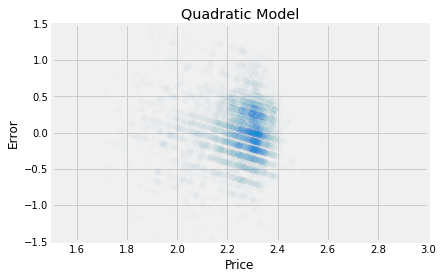

In [110]:
quadratic_model=make_pipeline(PolynomialFeatures(2), LinearRegression())
quadratic_model.fit(Xt_train,yt_train)
yt_train_predict=quadratic_model.predict(Xt_train)
residuals_t=yt_train-yt_train_predict

plt.scatter(yt_train_predict,residuals_t,alpha=.01)
plt.title("Quadratic Model")
plt.xlabel("Price")
plt.ylabel("Error")
plt.xlim((1.5,3))
plt.ylim((-1.5,1.5))
plt.show()

In [134]:
sm.stats.diagnostic.het_breuschpagan(residuals2,X2_train)

(150.6730947028409,
 1.886102615005244e-32,
 39.01014484581862,
 4.016184297038413e-32)

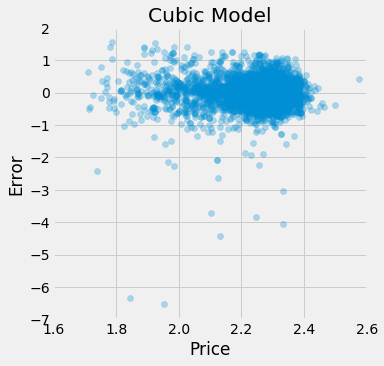

In [130]:
#Note that here 'X2, y2' refer to the transformed data, not the quadratic model
cubic_model=make_pipeline(PolynomialFeatures(3), LinearRegression())
cubic_model.fit(X2_train,y2_train)

y3_train_predict=cubic_model.predict(X2_train)
residuals3=y2_train-y3_train_predict

plt.scatter(y2_train_predict,residuals3,alpha=.3)
plt.xlabel("Price")
plt.ylabel("Error")
plt.title("Cubic Model")
plt.xlim((1.6,2.6))
plt.ylim((-7,2))
plt.show()

In [135]:
sm.stats.diagnostic.het_breuschpagan(residuals3,X2_train)

(145.8469189014133,
 2.0729095634408694e-31,
 37.716409965898634,
 4.7266311995610635e-31)

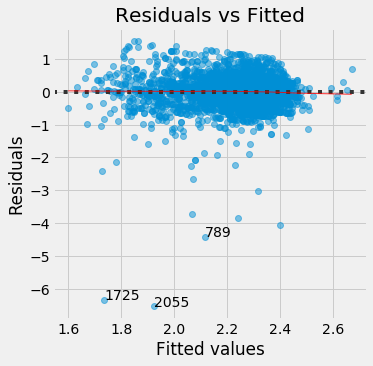

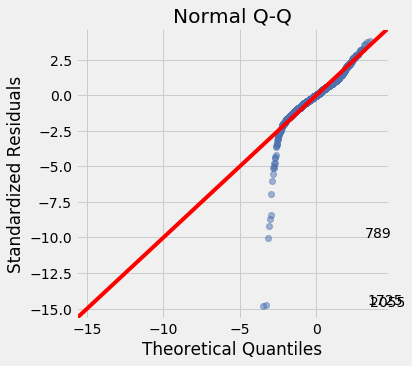

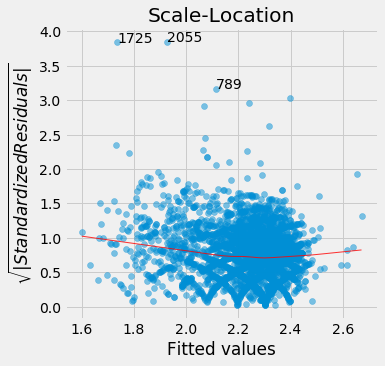

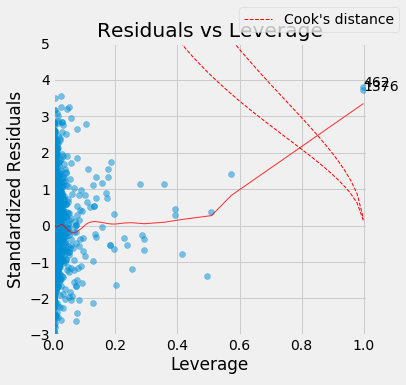

In [140]:
lr=LinearRegression()
poly=PolynomialFeatures(3)
X2_train_new=poly.fit_transform(X2_train)
lr_model=lr.fit(X2_train,y2_train)

cubic_df=pd.DataFrame(X2_train_new)
cubic_df['y3']=y2_train
diagnostic_plots.diagnostic_plots(cubic_df.drop('y3',axis=1),cubic_df['y3'],)

In [76]:
model_fit=sm.OLS(yt_train, sm.add_constant(Xt_train)).fit()
model_cooks=model_fit.get_influence().cooks_distance[0]
leverage=np.flip(np.argsort(model_cooks),0)
max(model_cooks)

0.47822642518639186

Next up:  Remove high leverage points, look at Huber loss and/or other scoring functions.

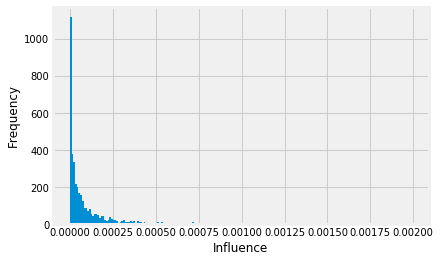

In [75]:
plt.hist(model_cooks,bins=np.arange(0,.002,.00001))
plt.xlabel("Influence")
plt.ylabel("Frequency")
plt.show()

We see that based on this histogram the maximum leverage point of .48 we found above is astronomically large.  We must destroy it.  Let's start by building a new dataframe.

In [102]:
df_train=pd.concat([pd.DataFrame(X_train,columns=["stars","pics","descriptors","desLength"]),pd.DataFrame(y_train,columns=['Price'])],axis=1)
df_train['leverage']=model_cooks
df_small=df_train[df_train.leverage<.00075]
df_small.shape

(4029, 6)

In [103]:
df_small.head()

,stars,pics,descriptors,desLength,Price,leverage
0,4.2,16.0,5.0,160.0,6.88,1.458533e-04
1,5.0,13.0,5.0,169.0,16.95,2.568514e-04
2,2.6,15.0,5.0,153.0,8.99,7.922717e-06
3,4.2,15.0,5.0,159.0,9.99,9.550676e-07
4,4.1,17.0,5.0,77.0,7.99,1.316902e-04


Now let's repeat our procedures above with the reduced dataset.

In [104]:
x_small=df_small.iloc[:,:4]
y_small=df_small.iloc[:,4:5]

In [108]:
ridge_scores=[]
alphas=[10**(float(i)) for i in np.arange(-10,1,1)]
best_alphas_small=[]
for i in range(1,8):
    degree=i
    est = make_pipeline(PolynomialFeatures(degree), RidgeCV(cv=4,alphas=alphas))
    # Fit our model to the training data
    fit_small=est.fit(x_small, y_small)
    s_train=fit_small.score(x_small,y_small)
    s_test=fit_small.score(X_test,y_test)
    y_small_predict=fit_small.predict(x_small)
    y_test_predict=fit_small.predict(X_test)
    #s_test2=R2(y_test_predict,y_test)
    scores = cross_val_score(est, Xt_train, yt_train, cv=4, scoring='mean_squared_error')
    mse=MSE(y_small_predict,y_small)
    ridge_scores.append([s_train,s_test,mse,np.mean(scores)])

    print(f"{i}:   4-fold Score: {s_train},  TS1: {s_test},   MSE: {mse}, CVS: {np.mean(scores)}")
    

1:   4-fold Score: 0.06676250128530747,  TS1: -0.004868298045443087,   MSE: 12.498672081557517, CVS: -0.20058037716551327
2:   4-fold Score: 0.07805819673404836,  TS1: -0.007871887792615606,   MSE: 12.347390983721843, CVS: -0.21380573955296622
3:   4-fold Score: 0.08112577619267092,  TS1: -0.012067569692038926,   MSE: 12.306307476265008, CVS: -1.631474511484125
4:   4-fold Score: 0.08664921189414798,  TS1: -0.09167867389626294,   MSE: 12.232333153875063, CVS: -40.06967058213685
5:   4-fold Score: 0.09790813544450283,  TS1: -12.649344971062517,   MSE: 12.081544535071137, CVS: -71468.60980970145
6:   4-fold Score: 0.10941553483706268,  TS1: -466.568994637631,   MSE: 11.927428126635775, CVS: -7436738.762426034
7:   4-fold Score: 0.13045338792486483,  TS1: -94537.5190341097,   MSE: 11.645672166972158, CVS: -8546942211.135173


Below, we record the diagnostic plots with no transformation for comparison.

In [1]:
X_train_new=poly.fit_transform(X_train)

cubic_df_raw=pd.DataFrame(X_train_new)
cubic_df_raw['y3']=y_train
diagnostic_plots.diagnostic_plots(cubic_df_raw.drop('y3',axis=1),cubic_df_raw['y3'])

NameError: name 'poly' is not defined

### Now let's try a simpler transformation

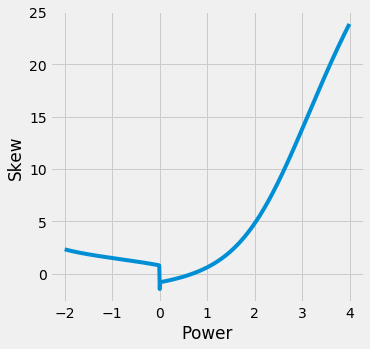

In [138]:
power=np.arange(-2,4,.01)
skew=[]
for k in np.arange(-2,4,.01):
    skew.append(stats.skew(df['desLength'].apply(lambda x: x**k)))

plt.plot(power,skew)
plt.xlabel('Power')
plt.ylabel('Skew')
plt.show()

Notice that a skew of zero is achieved somewhere between zero and one.  We can get the value more precisely as follows:

In [147]:
skew_min=sorted(zip(power,np.array(skew)**2),key=(lambda x: x[1]))[0]
skew_min

(0.6800000000000024, 1.0407190911647973e-05)

In [162]:
def transform(x):
    return x**skew_min[0]

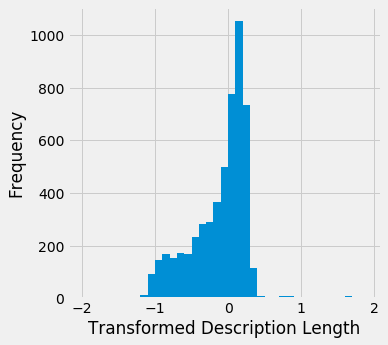

In [163]:
plt.hist(df['desLength'].apply(transform).apply(lambda x: (x-30)/10),bins=np.arange(-2,2,.1))
plt.xlabel("Transformed Description Length")
plt.ylabel("Frequency")
plt.show()

In [512]:
est = make_pipeline(PolynomialFeatures(2), LinearRegression())
skew_acc=[]
skew_acc_check=[]
for p in np.arange(-3,2,.01):
    df['dL_transformed_unskew']=df['desLength'].apply(lambda x: x**p)
    x3=df[['stars','pics','descriptors','dL_transformed_unskew']]
    y3=df.iloc[:,4:5].apply(np.log)
    X3_train, X3_test, y3_train, y3_test = train_test_split(x3.values, y3.values, test_size=0.2,random_state=42)
    fit3=est.fit(X3_train,y3_train)
    scores = cross_val_score(est, X3_train, y3_train, cv=4, scoring='mean_squared_error')
    skew_acc_check.append((p,fit3.score(X3_test,y3_test)))
    skew_acc.append((p,np.mean(scores)))

In [513]:
sorted(skew_acc_check,key=lambda x: x[1],reverse=False)[1]


(0.7099999999999209, 0.026822211924464656)

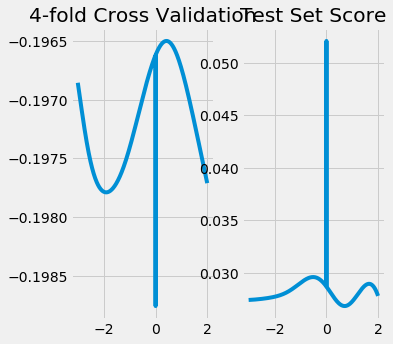

In [514]:
skew_x=[x[0] for x in skew_acc]
skew_y=[x[1] for x in skew_acc]
skew_x_test=[x[0] for x in skew_acc_check]
skew_y_test=[x[1] for x in skew_acc_check]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
ax1.plot(skew_x, skew_y)
ax1.set_title('4-fold Cross Validation')
ax2.plot(skew_x_test, skew_y_test)
ax2.set_title('Test Set Score')
plt.show()


#plt.plot(skew_x,skew_y)
#plt.xlabel('Power')
#plt.ylabel('4-fold Cross-Val Score')
#plt.show()

In [ ]:
So, our best model is quadratic, but with a data transform acting on the description length.